# DATA PREPROCESSING AND LOADING

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import numpy as np
import cv2
from tqdm import tqdm

In [0]:
base_dir = "/content/gdrive/My Drive/train"

In [0]:
train_dataset = os.listdir("/content/gdrive/My Drive/train")

In [0]:
def load_data(dataset,val_dir):

  coin_paths_val =  [ os.path.join(val_dir,dir)  for dir in dataset]
  from collections import defaultdict
  country2coins_val = defaultdict(list)
  for path in tqdm(coin_paths_val):
    country = (((path.split('/'))[-1]).split(','))[-1]
    for img in os.listdir(path):
      img_path = os.path.join(path,img)
      IMG = cv2.imread(img_path)
      IMG = cv2.resize(IMG, (224,224))
      IMG = np.array(IMG).astype('float32') / 255. 
      country2coins_val[country].append(IMG)

  country_labels_val = []
  for key in country2coins_val:
    if key not in country_labels_val:
      country_labels_val.append(key)

  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  numeric_labels_val = le.fit_transform(country_labels_val)

  label_dict_val = {country_labels_val[i]:numeric_labels_val[i] for i in range(len(country_labels_val))}

  X_val = []
  Y_categorical_val = []
  for key in country2coins_val:
    for img in country2coins_val[key]:
      X_val.append(img)
      Y_categorical_val.append(label_dict_val[key])
  import random
  combined_val = list(zip(X_val, Y_categorical_val))
  random.shuffle(combined_val)
  X_val[:], Y_categorical_val[:] = zip(*combined_val)

  from keras.utils import to_categorical
  Y_val = to_categorical(Y_categorical_val, num_classes = len(country_labels_val))

  return X_val, Y_val

In [0]:
coin_paths = [ os.path.join(base_dir,dir)  for dir in train_dataset]

In [0]:
from collections import defaultdict

country2coins = defaultdict(list)

In [9]:

for path in tqdm(coin_paths):
  country = (((path.split('/'))[-1]).split(','))[-1]
  for img in os.listdir(path):
    img_path = os.path.join(path,img)
    IMG = cv2.imread(img_path)
    IMG = cv2.resize(IMG, (224,224))
    IMG = np.array(IMG).astype('float32') / 255. 
    country2coins[country].append(IMG)

100%|██████████| 211/211 [44:32<00:00, 11.60s/it]


In [0]:
country_labels = []
for key in country2coins:
  if key not in country_labels:
    country_labels.append(key)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
numeric_labels = le.fit_transform(country_labels)

label_dict = {country_labels[i]:numeric_labels[i] for i in range(len(country_labels))}


In [0]:
reverse_label_dict = {numeric_labels[i]:country_labels[i] for i in range(len(country_labels))}

In [0]:
X = []
Y_categorical = []
for key in country2coins:
  for img in country2coins[key]:
    X.append(img)
    Y_categorical.append(label_dict[key])

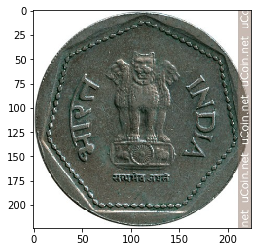

In [0]:
import matplotlib.pyplot as plt

plt.imshow(X[3000] , cmap='gray')

In [0]:
# randominzing the data
import random
combined = list(zip(X, Y_categorical))
random.shuffle(combined)
X[:], Y_categorical[:] = zip(*combined)

In [0]:
from keras.utils import to_categorical
Y = to_categorical(Y_categorical, num_classes = len(country_labels))

In [0]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [0]:
X_train = np.array(X)
y_train = np.array(Y)
#X_test  = np.array(X_test)

In [0]:
print("X_train shape:{}".format(X_train.shape))
print("Y_train shape:{}".format(y_train.shape))
#print("X_test shape:{}".format(X_test.shape))
#print("Y_test shape:{}".format(y_test.shape))

X_train shape:(7055, 224, 224, 3)
Y_train shape:(7055, 32)


# Model Building

In [0]:
from keras.models import Model
from keras.layers import Input, Flatten, Dropout, BatchNormalization
from keras.layers import Dense, Conv2D, MaxPooling2D

In [0]:
def classifier():
  z = Input(shape=(128,128,3))
  x = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128,128,3))(z)
  x = BatchNormalization()(x)

  x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)

  x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.2)(x)

  x = Flatten()(x)
  x = Dense(512, activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  x = Dense(128, activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  output = Dense(32 , activation = 'softmax')(x)

  return Model(inputs = z , outputs = output )



In [0]:
def classifier_256(classifier_128):
  from keras.models import Sequential
  model = Sequential()
  model.add(Conv2D(32 , kernel_size = (3,3), padding = 'same' , activation='relu', input_shape = (256,256,3)))
  model.add(BatchNormalization())

  # new
  model.add(Conv2D(32, kernel_size = (3,3) , padding = 'same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Conv2D(32 , kernel_size=(3,3) , padding = 'same' , activation = 'relu')) # newly added
  model.add(BatchNormalization())  # newly added
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))   # newly added
  model.add(Conv2D(3 , kernel_size = (3,3), padding = 'same' , activation='relu'))
  model.add(classifier_128)
  
  return model

In [0]:
from keras.models import load_model

classifier_128 = load_model("/content/gdrive/My Drive/coin_classifier_85acc.h5")

In [0]:
coin_classifier_256 = classifier_256(classifier_128)

In [0]:
coin_classifier_256.summary()
for i,layer in enumerate(coin_classifier_256.layers[10].layers[:15]):
  layer.trainable = False

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 256, 256, 32)     

In [0]:
for i,layer in enumerate(coin_classifier_256.layers[10].layers[15:]):
  layer.trainable = True

for i,layer in enumerate(coin_classifier_256.layers[:10]):
  layer.trainable = True


In [0]:
coin_classifier_256.compile(loss = 'categorical_crossentropy' , optimizer = 'RMSProp' , metrics = ['accuracy'])

In [0]:
coin_classifier_256.fit(X_train, y_train , epochs = 60 , validation_split = 0.1 , batch_size = 16 , shuffle = True)

Train on 5079 samples, validate on 565 samples
Epoch 1/60
5079/5079 [==============================] - 101s 20ms/step - loss: 0.1147 - acc: 0.9681 - val_loss: 0.2852 - val_acc: 0.9345
Epoch 2/60
5079/5079 [==============================] - 101s 20ms/step - loss: 0.0892 - acc: 0.9760 - val_loss: 0.3452 - val_acc: 0.9204
Epoch 3/60
5079/5079 [==============================] - 101s 20ms/step - loss: 0.0994 - acc: 0.9713 - val_loss: 0.3876 - val_acc: 0.9027
Epoch 4/60
5079/5079 [==============================] - 101s 20ms/step - loss: 0.0907 - acc: 0.9724 - val_loss: 0.3303 - val_acc: 0.9168
Epoch 5/60
5079/5079 [==============================] - 101s 20ms/step - loss: 0.0856 - acc: 0.9748 - val_loss: 0.3615 - val_acc: 0.9239
Epoch 6/60
5079/5079 [==============================] - 101s 20ms/step - loss: 0.0870 - acc: 0.9750 - val_loss: 0.3265 - val_acc: 0.9221
Epoch 7/60
5079/5079 [==============================] - 101s 20ms/step - loss: 0.0869 - acc: 0.9750 - val_loss: 0.2895 - val_acc: 0

KeyboardInterrupt: ignored

In [0]:
import tensorflow as tf
coin_classifier = classifier()
coin_classifier.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

In [0]:
coin_classifier.fit(X_train, y_train , epochs = 30 , validation_split = 0.1 , batch_size = 16 , shuffle = True)

In [0]:
loss, accuracy = coin_classifier_256.evaluate(X_test, y_test)

1411/1411 [==============================] - 9s 6ms/step


In [0]:
print("Test LOSS:{}".format(loss))
print("Test Accuracy:{}".format(accuracy*100))

Test LOSS:0.5209057128757544
Test Accuracy:89.79447200566973


In [0]:
y_pred = coin_classifier.predict(X_test)

In [0]:
y_pred_labels = []
y_test_labels = []
for y in y_pred:
  y_pred_labels.append(((np.where(y == y.max()))[0][0]))

for y in y_test:
  y_test_labels.append(((np.where(y == y.max()))[0][0]))

In [0]:
predictions = []
for label in y_pred_labels:
  predictions.append(reverse_label_dict[label])



# VGG-19


In [0]:
from keras.applications.vgg19 import VGG19
from keras.models import Sequential

In [0]:
vgg_19_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')

In [0]:
vgg_19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
def vgg_19_classifier(base):
  model = Sequential()
  model.add(base)
  
  model.add(Dense(256, activation = 'relu'))
  model.add(BatchNormalization())
  #model.add(Dropout(0.25))

  model.add(Dense(128, activation = 'relu'))
  model.add(BatchNormalization())
  #model.add(Dropout(0.25))

  model.add(Dense(32, activation = 'softmax'))
  return model

In [0]:
cls = vgg_19_classifier(vgg_19_model)

In [0]:
cls.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)              

In [0]:
for i,layer in enumerate(cls.layers[0].layers):
  print(i,layer.name)

0 input_5
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d_4


In [0]:
for layer in cls.layers[0].layers[:16]:
  layer.trainable = False
for layer in cls.layers[0].layers[16:]:
  layer.trainable = True
for layer in cls.layers[1:]:
  layer.trainable = True

In [0]:
from keras.optimizers import Nadam, RMSprop
opt = RMSprop(lr=0.0002)

In [0]:
cls.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
cls.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=16)

Train on 6349 samples, validate on 706 samples
Epoch 1/50
6349/6349 [==============================] - 101s 16ms/step - loss: 3.7042 - acc: 0.0775 - val_loss: 14.9232 - val_acc: 0.0354
Epoch 2/50
6349/6349 [==============================] - 97s 15ms/step - loss: 2.8089 - acc: 0.2523 - val_loss: 9.2945 - val_acc: 0.1317
Epoch 3/50
6349/6349 [==============================] - 97s 15ms/step - loss: 2.1010 - acc: 0.4186 - val_loss: 11.7091 - val_acc: 0.0453
Epoch 4/50
6349/6349 [==============================] - 97s 15ms/step - loss: 1.6059 - acc: 0.5669 - val_loss: 12.9715 - val_acc: 0.0694
Epoch 5/50
6349/6349 [==============================] - 97s 15ms/step - loss: 1.1939 - acc: 0.6885 - val_loss: 5.5427 - val_acc: 0.1360
Epoch 6/50
6349/6349 [==============================] - 97s 15ms/step - loss: 0.9152 - acc: 0.7721 - val_loss: 4.0997 - val_acc: 0.2776
Epoch 7/50
6349/6349 [==============================] - 97s 15ms/step - loss: 0.6655 - acc: 0.8471 - val_loss: 1.6290 - val_acc: 0.60

KeyboardInterrupt: ignored

# Transfer Learning

In [0]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential

In [0]:
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))

In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
def transfer_classifier(base):

  model = Sequential()
  model.add(base)
  model.add(GlobalAveragePooling2D())
  
  model.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
  model.add(BatchNormalization())
  #odel.add(Dropout(0.5))


  model.add(Dense(32, activation = 'softmax'))
  return model

In [0]:
cls = transfer_classifier(base_model)
#cls.output_shape

In [0]:
for i,layer in enumerate(cls.layers[0].layers):
  print(i,layer.name)
for i,layer in enumerate(cls.layers):
  print(i,layer.name)

0 input_6
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
0 vgg16
1 global_average_pooling2d_5
2 dense_14
3 batch_normalization_9
4 dense_15


In [0]:
for i,layer in enumerate(cls.layers[0].layers[:13]):
  layer.trainable = False
for i,layer in enumerate(cls.layers[0].layers[13:]):
  layer.trainable = True
for i,layer in enumerate(cls.layers[1:]):
  layer.trainable = True

In [0]:
from keras.optimizers import RMSprop

opt = RMSprop(lr = 0.0001)

In [0]:
cls.compile(loss = 'categorical_crossentropy', optimizer=opt , metrics=['accuracy'])

In [0]:
cls.fit(X_train, y_train, epochs = 50, batch_size=16, validation_split=0.1)

Train on 6349 samples, validate on 706 samples
Epoch 1/50
6349/6349 [==============================] - 87s 14ms/step - loss: 2.6974e-04 - acc: 1.0000 - val_loss: 0.3171 - val_acc: 0.9363
Epoch 2/50
6349/6349 [==============================] - 87s 14ms/step - loss: 6.0656e-04 - acc: 0.9998 - val_loss: 0.2849 - val_acc: 0.9363
Epoch 3/50
6349/6349 [==============================] - 87s 14ms/step - loss: 2.9724e-04 - acc: 1.0000 - val_loss: 0.1921 - val_acc: 0.9603
Epoch 4/50
 128/6349 [..............................] - ETA: 1:18 - loss: 2.4851e-04 - acc: 1.0000

KeyboardInterrupt: ignored

In [0]:
 test_loss, test_accuracy = cls.evaluate(X_val, y_val)

1688/1688 [==============================] - 15s 9ms/step


In [0]:
print("Test Loss:{}".format(test_loss))
print("Test Accuracy:{}".format(test_accuracy*100))

Test Loss:0.10456489874543821
Test Accuracy:97.74881516587678


# TESTING 

In [0]:
test_dir = "/content/gdrive/My Drive/test"

In [0]:
from keras.models import load_model
test_model = load_model("/content/gdrive/My Drive/coin_classifier_256_vgg_v2.h5")

In [0]:
def get_labels(predictions):
  _ = []
  for y in predictions:
    idx = ((np.where(y == y.max()))[0][0])
    _.append(reverse_label_dict[idx])

  return _

In [0]:
test_results = {}
for img in tqdm(os.listdir(test_dir)):
  id = img.split('.')[0]
  img_path = os.path.join(test_dir,img)
  
  IMG = cv2.imread(img_path)
  IMG = cv2.resize(IMG,(224,224))
  IMG = np.array(IMG).astype('float32') / 255. 
  prediction = cls.predict(np.expand_dims(IMG, axis=0))
  label = (get_labels(prediction))[0]
  test_results[id] = label




100%|██████████| 1055/1055 [00:32<00:00, 32.96it/s]


In [0]:
test_images_array = np.array(test_images)
test_predictions = coin_classifier.predict(test_images_array)
labels = get_labels(test_predictions)

In [0]:
test_results['1']

'thailand'

In [0]:
idx2labels = {i+1:labels[i] for i in range(len(labels))}

In [0]:
import csv
with open('/content/gdrive/My Drive/output_12.csv','w') as f:
  for key in test_results.keys():
    f.write("%s,%s\n"%(key,test_results[key]))

In [0]:
# saving the model
cls.save("/content/gdrive/My Drive/coin_classifier_256_vgg_v5.h5")

In [0]:
test_results['']

'thailand'